In [4]:
from sqlalchemy.orm import relationship, sessionmaker
from sqlalchemy import create_engine
from database import Reactions

engine = create_engine('sqlite:///reactions2.db', echo = False)

Session = sessionmaker(bind=engine)
session = Session()

2023-06-20 18:12:02,188 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-06-20 18:12:02,188 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("reactions")
2023-06-20 18:12:02,189 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-20 18:12:02,189 INFO sqlalchemy.engine.Engine COMMIT


In [5]:
def getRxnFP(r, fp_type, summed, multipliers):
    if fp_type == "MACCS":
        rxnMatrix = np.zeros((5,167))
    else:
        rxnMatrix = np.zeros((5,2048))
    row = 0
    for k,m in zip(reagent_classes,multipliers):
        sm = getattr(r,k)
        if sm == "NONE":
            fp = np.zeros((1,))
        else:
            if k == "solvent":
                mol = Chem.MolFromSmiles(solv_map[sm])
                if fp_type == "MACCS":
                    DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp)
                else:
                    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp)
                if "%" in sm:
                    s2 = sm.split("_")[1]
                    mol2 = Chem.MolFromSmiles(solv_map[s2])
                    fp2 = np.zeros((1,))
                    if fp_type == "MACCS":
                        DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp2)
                    else:
                        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp2)

                    fp = np.add(fp,fp2)
            else:
                mol = Chem.MolFromSmiles(sm)
                fp = np.zeros((1,))
                if fp_type == "MACCS":
                    DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp)
                else:
                    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp)
        fp = fp*m
        rxnMatrix[row,:] = fp
        row = row + 1
    if summed:
        return np.sum(rxnMatrix, axis=0)
    else:
        return rxnMatrix

In [6]:
r = session.query(Reactions).all()


/var/folders/8k/w__0g4xs7rj0xv7hk3dqm71w0000gn/T/ipykernel_28791/3822804417.py:1: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  r = session.query(Reactions).all()


In [7]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem, MACCSkeys
import pandas as pd

reagent_classes = ["electrophile", "nucleophile", "catalyst_smiles", "base_smiles", "solvent"]
solv_map = {"NMP":'O=C1N(C)CCC1', "DMSO":'O=S(C)C',"DMF":'O=CN(C)C', \
            "25%H2O_NMP":'[H]O[H].O=C1N(C)CCC1', "25%H2O_DMSO":'O=S(C)C.[H]O[H]', "25%H2O_DMF":'O=CN(C)C.[H]O[H]', \
            "25%tAmOH_DMSO":"CCC(C)(O)C.O=S(C)C","10%tAmOH_NMP":"CCC(C)(O)C.O=C1N(C)CCC1"}

class_reagents = {k:[] for k in reagent_classes}
multipliers = [1, 1, 1, 1, 1.5]
yields = []
index_split_by_class = {k:[] for k in reagent_classes}
rxnfps = []
yield_group = []
for k in r:
    if "Suzuki" not in k.reaction_name:
        continue
    if k.output_value > 100:
        continue
    for j in reagent_classes:
        if j=="solvent":
            mol=Chem.MolFromSmiles(solv_map[getattr(k,j)])
            sm = solv_map[getattr(k,j)]
        else:
            mol = Chem.MolFromSmiles(getattr(k,j))
            sm = getattr(k,j)
        if sm not in class_reagents[j]:
            class_reagents[j].append(sm)

        index_split_by_class[j].append(class_reagents[j].index(sm))
    n = k.group
    if k.output_value == 0:
        yield_group.append(0)
    elif k.output_value < 33:
        yield_group.append(1)
    elif k.output_value < 66:
        yield_group.append(2)
    else:
        yield_group.append(3)

    yields.append(float(k.output_value))
    fp = getRxnFP(k, "MFP4", True, multipliers)
    rxnfps.append(fp)

In [8]:
print(len(index_split_by_class["electrophile"]), len(X_TSNE_RFP), len(rxnfps))

NameError: name 'X_TSNE_RFP' is not defined

In [9]:
for k in class_reagents:
    print(k, len(class_reagents[k]))

electrophile 15
nucleophile 34
catalyst_smiles 18
base_smiles 8
solvent 8


In [10]:
from sklearn.manifold import TSNE

X_TSNE_RFP = TSNE(n_components=2, n_jobs=-1, random_state=2).fit_transform(rxnfps)


/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


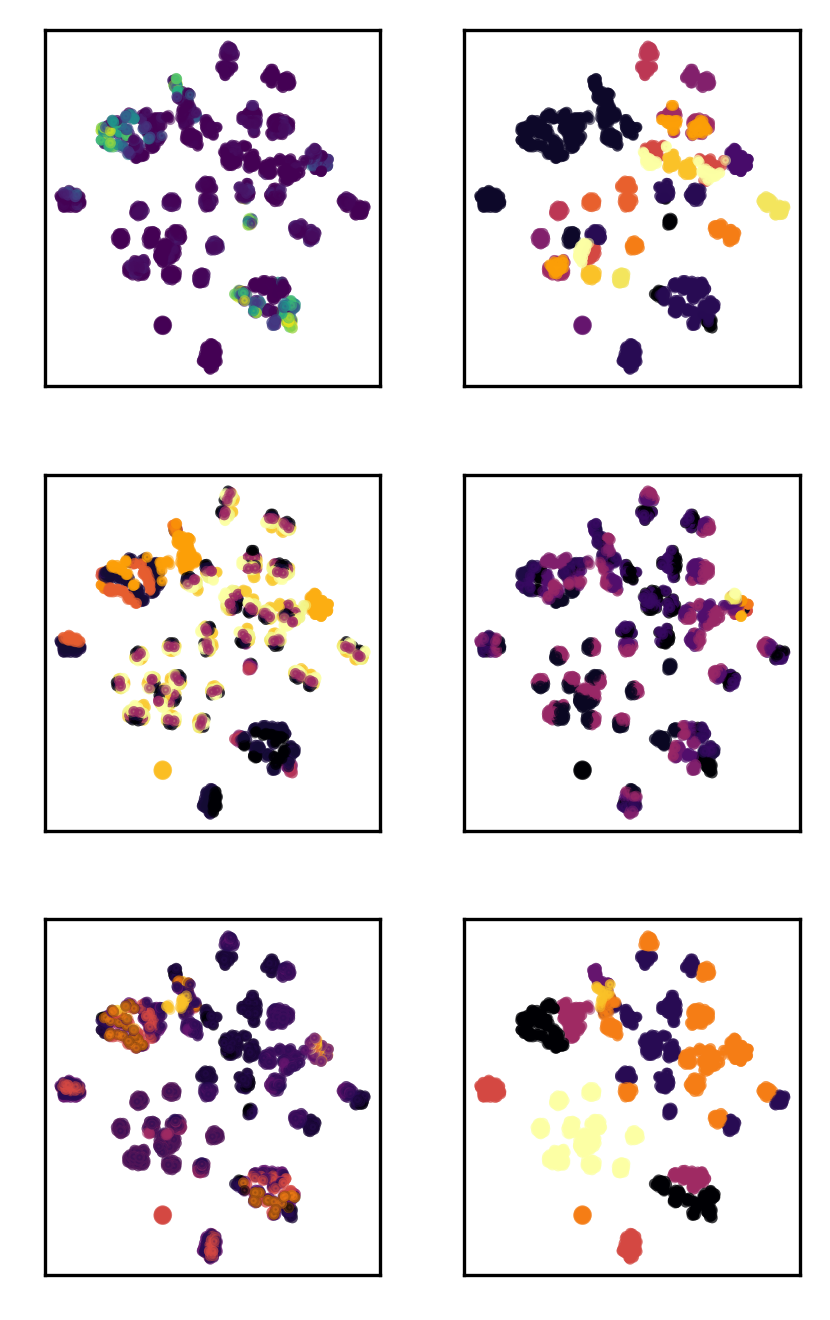

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,2, figsize=(3.25,5.5), dpi=300)
ax[0][0].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='viridis', c=yields, alpha=.5, marker='.',s=10, vmax=100, vmin = 0)
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])
# ax[0][0].set_title("PROD/IS", fontfamily="arial", fontsize=6)
# ax[0][0].set_xlabel("tsne$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
# ax[0][0].set_ylabel("tsne$_y$", fontweight="bold", fontfamily="arial", fontsize=6)

ax[0][1].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["electrophile"], alpha=.5, marker='.',s=10)
ax[0][1].set_xticks([])
ax[0][1].set_yticks([])
# ax[0][1].set_title("Electrophile", fontfamily="arial", fontsize=6)
# ax[0][1].set_xlabel("tsne$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
# ax[0][1].set_ylabel("tsne$_y$", fontweight="bold", fontfamily="arial", fontsize=6)

ax[1][0].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["nucleophile"], alpha=.5, marker='.',s=10)
ax[1][0].set_xticks([])
ax[1][0].set_yticks([])
# ax[1][0].set_title("Nucleophile", fontfamily="arial", fontsize=6)
# ax[1][0].set_xlabel("tsne$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
# ax[1][0].set_ylabel("tsne$_y$", fontweight="bold", fontfamily="arial", fontsize=6)

ax[1][1].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["catalyst_smiles"], alpha=.5, marker='.',s=10)
ax[1][1].set_xticks([])
ax[1][1].set_yticks([])
# ax[1][1].set_title("Catalyst", fontfamily="arial", fontsize=6)
# ax[1][1].set_xlabel("tsne$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
# ax[1][1].set_ylabel("tsne$_y$", fontweight="bold", fontfamily="arial", fontsize=6)

ax[2][0].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["base_smiles"], alpha=.5, marker='.',s=10)
ax[2][0].set_xticks([])
ax[2][0].set_yticks([])
# ax[2][0].set_title("Base", fontfamily="arial", fontsize=6)
# ax[2][0].set_xlabel("tsne$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
# ax[2][0].set_ylabel("tsne$_y$", fontweight="bold", fontfamily="arial", fontsize=6)


ax[2][1].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["solvent"], alpha=.5, marker='.',s=10)
ax[2][1].set_xticks([])
ax[2][1].set_yticks([])
# ax[2][1].set_title("Solvent", fontfamily="arial", fontsize=6)
# ax[2][1].set_xlabel("tsne$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
# ax[2][1].set_ylabel("tsne$_y$", fontweight="bold", fontfamily="arial", fontsize=6)


# plt.tight_layout()
plt.subplots_adjust(wspace=.25, hspace=.25)

plt.savefig('figure1tsne_new_test.png', dpi=300, bbox_inches='tight',pad_inches=0.01)

BrC1=CC=CN=C1
CC(C(C)(C)O1)(C)OB1C2=CN(CC3=CC=CC=C3)N=C2


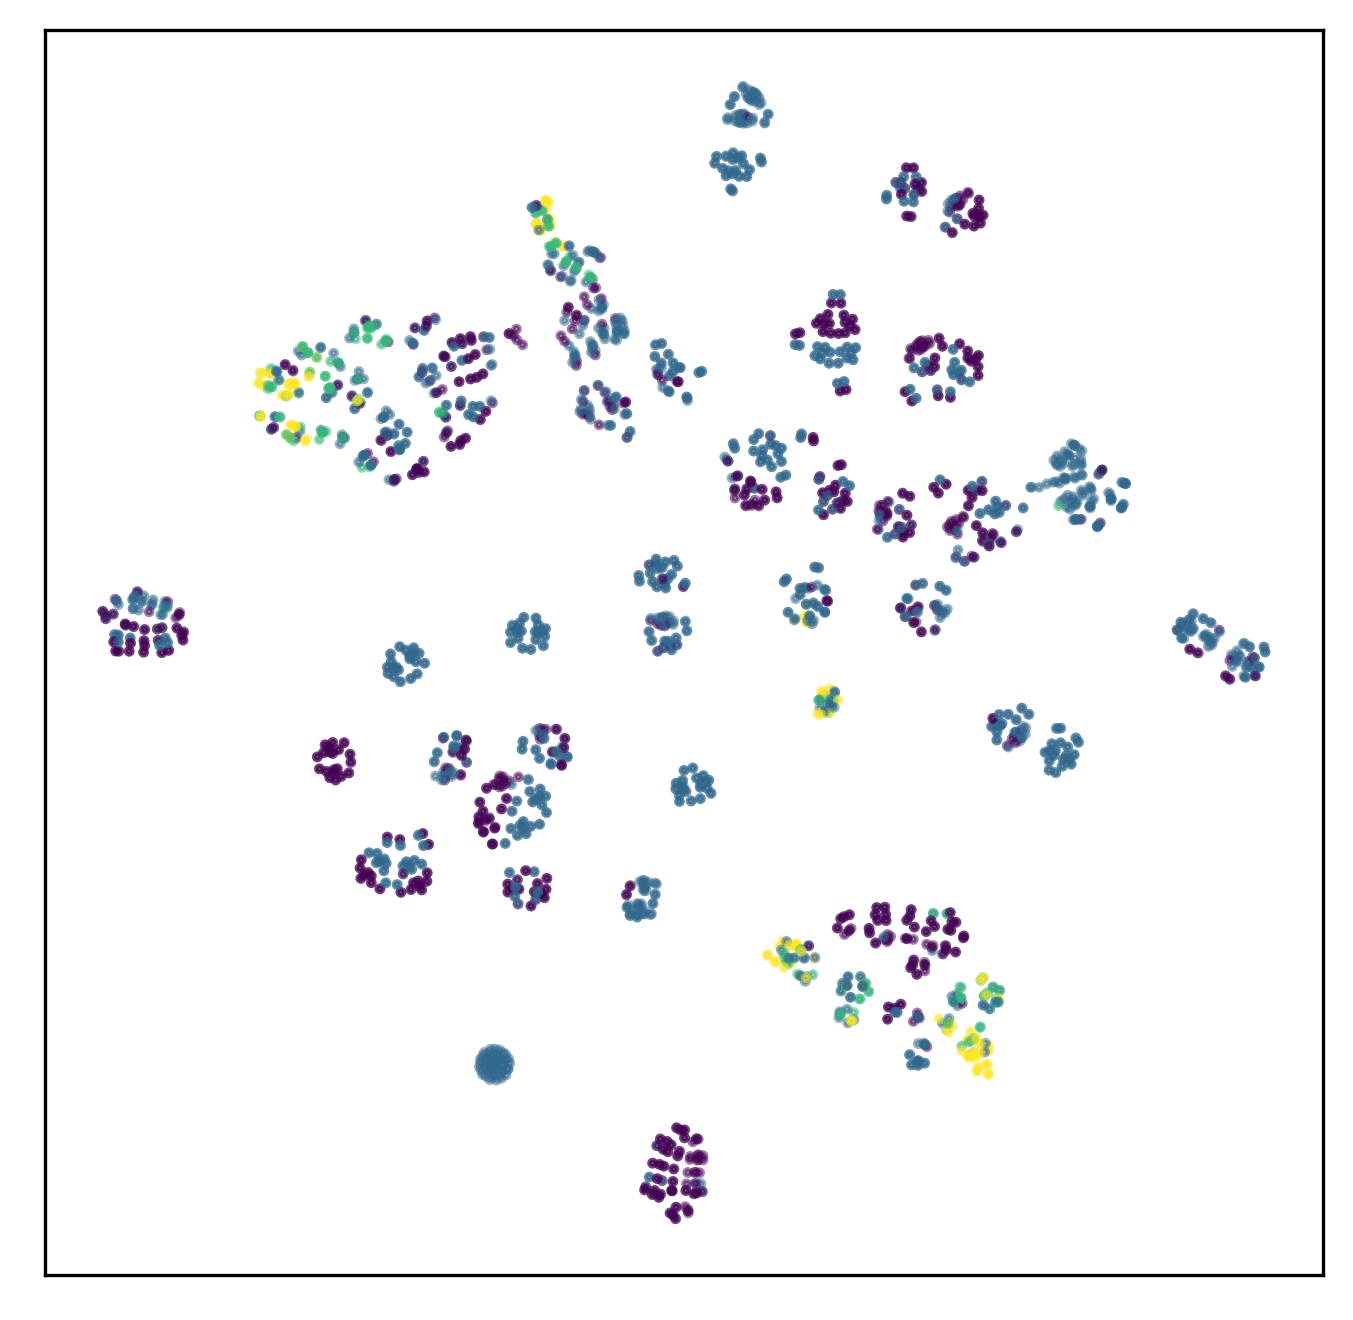

In [19]:
# print(index_split_by_class["electrophile"])
fig, ax = plt.subplots(figsize=(5.5,5.5), dpi=300)
ax.scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='viridis', c=yield_group, alpha=.5, marker='.',s=10, vmax=3, vmin = 0)
# for i,k in enumerate(index_split_by_class["electrophile"]):
#     ax.text(X_TSNE_RFP[i,0], X_TSNE_RFP[i,1], s=k,fontsize=4, fontfamily="arial")
ax.set_xticks([])
ax.set_yticks([])

plt.subplots_adjust(wspace=0, hspace=0)

print(class_reagents["electrophile"][3])
print(class_reagents["nucleophile"][27])

plt.savefig('figure1tsne_new_large_test.png', dpi=300, bbox_inches='tight',pad_inches=0.01)

In [4]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem, MACCSkeys
import pandas as pd

reagent_classes = ["electrophile", "nucleophile", "catalyst_smiles", "base_smiles", "solvent"]
solv_map = {"NMP":'O=C1N(C)CCC1', "DMSO":'O=S(C)C',"DMF":'O=CN(C)C', \
            "25%H2O_NMP":'[H]O[H].O=C1N(C)CCC1', "25%H2O_DMSO":'O=S(C)C.[H]O[H]', "25%H2O_DMF":'O=CN(C)C.[H]O[H]', \
            "25%tAmOH_DMSO":"CCC(C)(O)C.O=S(C)C","10%tAmOH_NMP":"CCC(C)(O)C.O=C1N(C)CCC1"}

multipliers = [1, 1, 1, 1, 1]
rxnfps = []
yields = []
data = {k:[] for k in reagent_classes}
smiles_to_name = {}
smiles_to_yields = {}
true_yields = []
yields_split_by_class = {k:{} for k in reagent_classes}
fps_split_by_class = {k:[] for k in reagent_classes}
index_split_by_class = {k:[] for k in reagent_classes}

ordered_smiles_by_class = {k:{} for k in reagent_classes}
remove_outlier_fp = []
for k in r:
    if "Suzuki" not in k.reaction_name:
        continue
    fp = getRxnFP(k, "MFP4", True, multipliers)
    rxnfps.append(fp)
    if float(k.output_value) <= 100:
        remove_outlier_fp.append(fp)
    true_yields.append(float(k.output_value))
    n = k.group
    if n == "0":
        yields.append(0)
    elif n == "low":
        yields.append(1)
    elif n == "med":
        yields.append(2)
    else:
        yields.append(3)
        

    for i,j in enumerate(reagent_classes):
        data[j].append(getattr(k,j))
        if j == "catalyst_smiles":
            smiles_to_name[getattr(k,j)] = k.catalyst
            if getattr(k,j) not in smiles_to_yields:
                smiles_to_yields[getattr(k,j)] = []
            smiles_to_yields[getattr(k,j)].append(k.output_value)
        if j == "base_smiles":
            smiles_to_name[getattr(k,j)] = k.base
        
        if float(k.output_value) > 100:
            continue
            

        if j=="solvent":
            mol=Chem.MolFromSmiles(solv_map[getattr(k,j)])
            sm = solv_map[getattr(k,j)]
        else:
            mol = Chem.MolFromSmiles(getattr(k,j))
            sm = getattr(k,j)

        if sm not in ordered_smiles_by_class[j]:
            fp = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp)

            ordered_smiles_by_class[j][sm]= fp
            
        if sm not in yields_split_by_class[j]:
            yields_split_by_class[j][sm] = []

        yields_split_by_class[j][sm].append(float(k.output_value))

print(len(rxnfps), len(yields))

2786 2786


In [18]:
print(np.max(X_TSNE_RFP[:,0]))
print(X_TSNE_RFP[:,0] > 60)

69.18744
[False False False ... False False False]


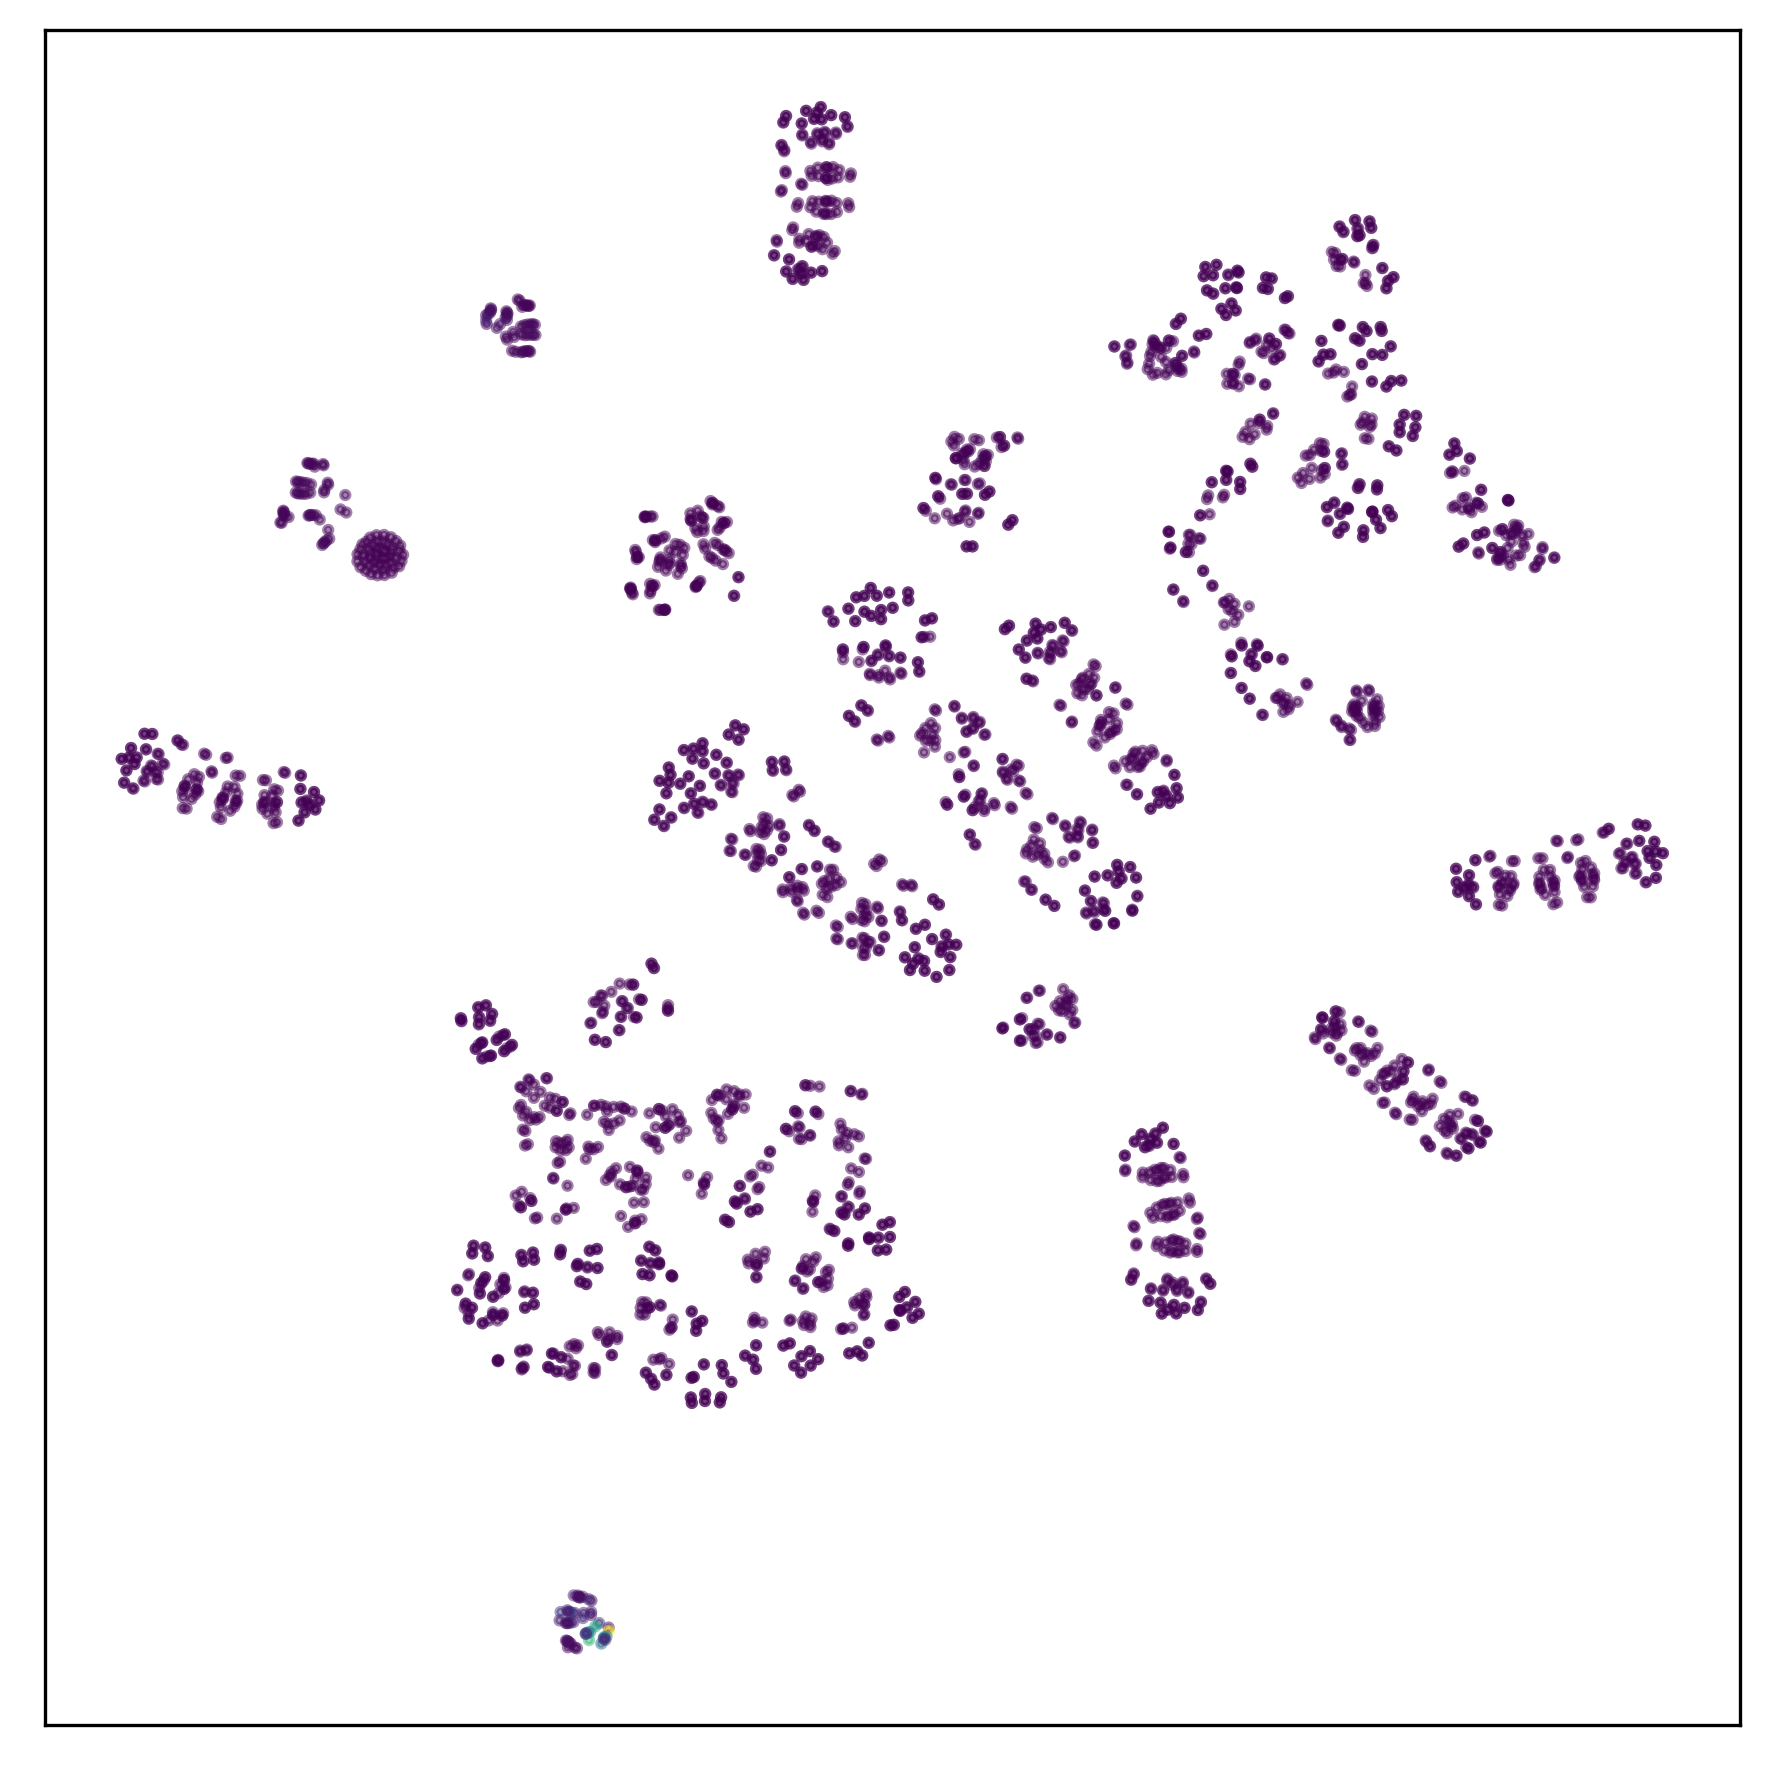

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,2, figsize=(6,6), dpi=300)
ax.scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='viridis', c=true_yields, alpha=.5, marker='.',s=15)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.savefig('figure1tsne_new.png', dpi=300, bbox_inches='tight',pad_inches=0.0)

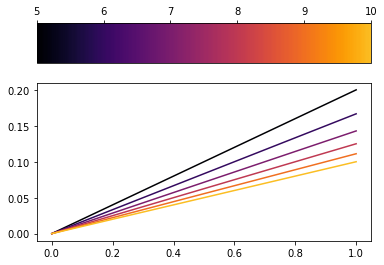

In [85]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

gs = gridspec.GridSpec(2, 1,
                       height_ratios=[1, 4]
                       )
ax = [plt.subplot(g) for g in gs]

parameterToColorBy = np.linspace(5, 10, 6, dtype=float)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

minColor = 0.00
maxColor = 0.85
inferno_t = truncate_colormap(plt.get_cmap("inferno"), minColor, maxColor)

colors = [inferno_t(i)
          for i in np.linspace(0, 1, parameterToColorBy.shape[0])]

norm = mpl.colors.Normalize(parameterToColorBy[0],
                            parameterToColorBy[-1])

cb = mpl.colorbar.ColorbarBase(ax[0],
                               cmap=inferno_t,
                               norm=norm,
                               ticks=parameterToColorBy,
                               orientation='horizontal')

ax[0].xaxis.set_ticks_position('top')

for p, c in zip(parameterToColorBy, colors):
    ax[1].plot(np.arange(2)/p, c=c)

plt.savefig("cbar.png",dpi=900)

In [12]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem, MACCSkeys
import pandas as pd

reagent_classes = ["electrophile", "nucleophile", "catalyst_smiles", "base_smiles", "solvent"]
solv_map = {"NMP":'O=C1N(C)CCC1', "DMSO":'O=S(C)C',"DMF":'O=CN(C)C', \
            "25%H2O_NMP":'[H]O[H].O=C1N(C)CCC1', "25%H2O_DMSO":'O=S(C)C.[H]O[H]', "25%H2O_DMF":'O=CN(C)C.[H]O[H]', \
            "25%tAmOH_DMSO":"CCC(C)(O)C.O=S(C)C","10%tAmOH_NMP":"CCC(C)(O)C.O=C1N(C)CCC1"}

multipliers = [
    [5, 1, 1, 1, 1],
    [1, 5, 1, 1, 1],
    [1, 1, 5, 1, 1],
    [1, 1, 1, 5, 1],
    [1, 1, 1, 1, 5]
]

rxnfps_split_by_class = {k:[] for k in reagent_classes}
for rc, mul in zip(reagent_classes, multipliers):
    index_split_by_class = {k:[] for k in reagent_classes}
    class_reagents = {k:[] for k in reagent_classes}
    class_names = {k:[] for k in reagent_classes}
    yields = []
    yield_group= []

    for k in r:
        if "Suzuki" not in k.reaction_name:
            continue
        if k.output_value > 100:
            continue
        if Chem.MolToSmiles(Chem.MolFromSmiles(getattr(k,"nucleophile"))) == Chem.MolToSmiles(Chem.MolFromSmiles("CC1(C)C(OB(C2=CN(N=C2)CC3=CC=CC=C3)O1)(C)C")):
            if Chem.MolToSmiles(Chem.MolFromSmiles(getattr(k,"electrophile"))) == Chem.MolToSmiles(Chem.MolFromSmiles("BrC1=CC=CN=C1")):

                for j in reagent_classes:
                    if j=="solvent":
                        mol=Chem.MolFromSmiles(solv_map[getattr(k,j)])
                        sm = solv_map[getattr(k,j)]
                    else:
                        mol = Chem.MolFromSmiles(getattr(k,j))
                        sm = getattr(k,j)
                    if sm not in class_reagents[j]:
                        class_reagents[j].append(sm)
                        if j == "catalyst_smiles":
                            class_names[j].append(k.catalyst)

                    index_split_by_class[j].append(class_reagents[j].index(sm))
                n = k.group
                if n == "0":
                    yield_group.append(0)
                elif n == "low":
                    yield_group.append(1)
                elif n == "med":
                    yield_group.append(2)
                else:
                    yield_group.append(3)

                yields.append(float(k.output_value))
                fp = getRxnFP(k, "MFP4", True, mul)
                rxnfps_split_by_class[rc].append(fp)

In [13]:
for k in class_reagents:
    print(k, len(class_reagents[k]))

electrophile 1
nucleophile 1
catalyst_smiles 16
base_smiles 6
solvent 1


In [14]:
import matplotlib

cmap = matplotlib.cm.get_cmap("inferno")

for k in class_reagents["base_smiles"]:
    print(k, matplotlib.colors.to_hex(cmap(class_reagents["base_smiles"].index(k)/(len(class_reagents["base_smiles"])-1))))
    

# for k in type_lists["solvent"]:
#     print(k, matplotlib.colors.to_hex(cmap(type_lists["solvent"].index(k)/(len(type_lists["solvent"])-1))))
    
# for k in type_lists["base_smiles"]:
#     print(k, matplotlib.colors.to_hex(cmap(type_lists["base_smiles"].index(k)/(len(type_lists["base_smiles"])-1))))

# for k in type_lists["catalyst_smiles"]:


C1CCN2CCCN=C2CC1 #000004
CN1CCCN2CCCN=C12 #420a68
CN(C)C(N(C)C)=NC(C)(C)C #932667
[P]1(N(CC)CC)(=NC(C)(C)C)N(CCCN1C)C #dd513a
CC(C)(C)N=[P](N1CCCC1)(N2CCCC2)N3CCCC3 #fca50a
C(N=[P](N(C)C)(N=[P](N(C)C)(N(C)C)N(C)C)N(C)C)C #fcffa4


In [15]:
print(len(rxnfps_split_by_class["electrophile"]))
print(len(yields))

96
96


/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/sklearn-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


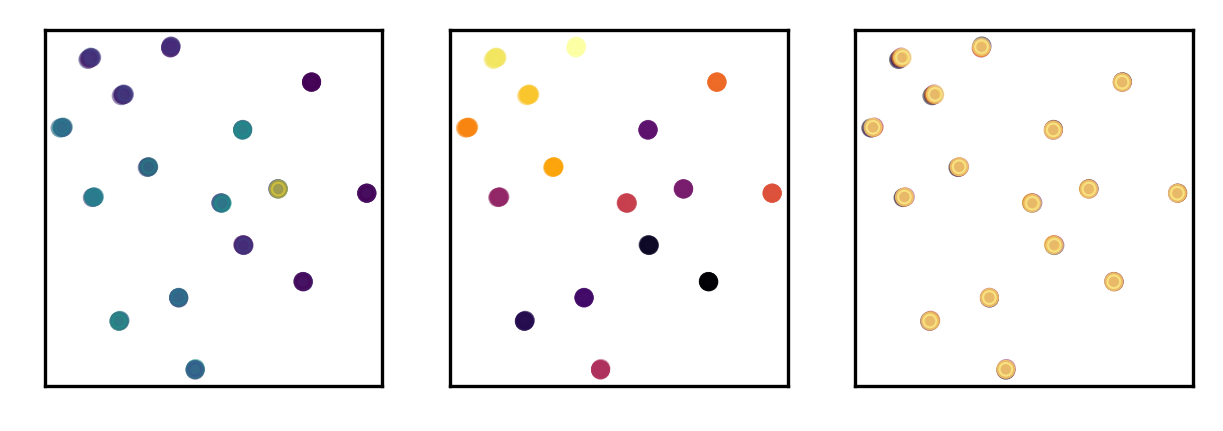

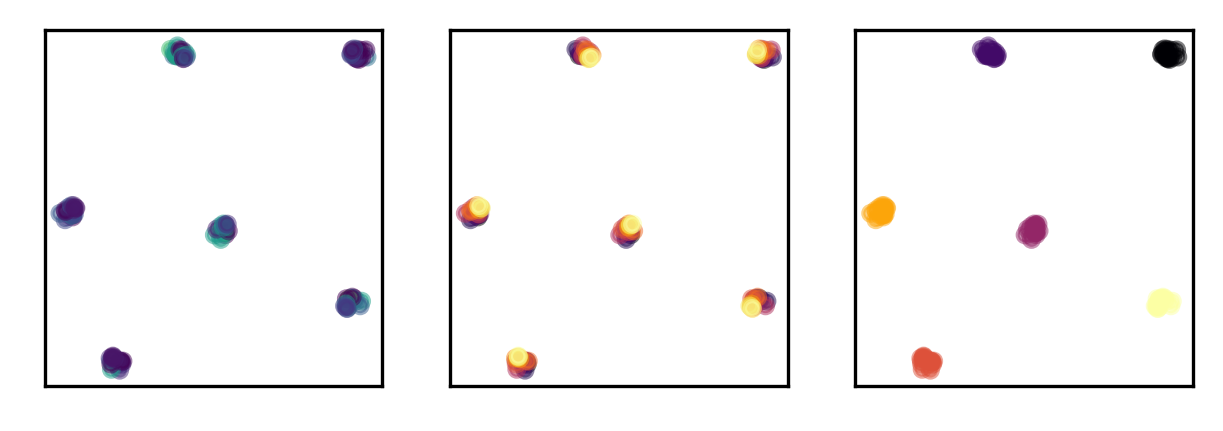

In [19]:
for k in ["catalyst_smiles", "base_smiles"]:
    # print(k)
    X_TSNE_RFP = TSNE(n_components=2, n_jobs=-1, random_state=1).fit_transform(rxnfps_split_by_class[k])

    fig, ax = plt.subplots(1,3, figsize=(4.94, 1.575), dpi=300)
    
    ax[0].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='viridis', c=yields, alpha=.5, marker='.',s=50)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    # ax[0][0].set_title("PROD/IS", fontfamily="arial", fontsize=6)
    # ax[0][0].set_xlabel("tsne$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
    # ax[0][0].set_ylabel("tsne$_y$", fontweight="bold", fontfamily="arial", fontsize=6)

    ax[1].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["catalyst_smiles"], alpha=.5, marker='.',s=50)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    # ax[0][1].set_title("Electrophile", fontfamily="arial", fontsize=6)
    # ax[0][1].set_xlabel("tsne$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
    # ax[0][1].set_ylabel("tsne$_y$", fontweight="bold", fontfamily="arial", fontsize=6)

    ax[2].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["base_smiles"], alpha=.5, marker='.',s=50)
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    # ax[1][0].set_title("Nucleophile", fontfamily="arial", fontsize=6)
    # ax[1][0].set_xlabel("tsne$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
    # ax[1][0].set_ylabel("tsne$_y$", fontweight="bold", fontfamily="arial", fontsize=6)

#     ax[2].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["catalyst_smiles"], alpha=.5, marker='.',s=10)
#     ax[2].set_xticks([])
#     ax[2].set_yticks([])
    # ax[1][1].set_title("Catalyst", fontfamily="arial", fontsize=6)
    # ax[1][1].set_xlabel("tsne$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
    # ax[1][1].set_ylabel("tsne$_y$", fontweight="bold", fontfamily="arial", fontsize=6)

    # ax[4].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["base_smiles"], alpha=.5, marker='.',s=10)
    # ax[4].set_xticks([])
    # ax[4].set_yticks([])
    # ax[2][0].set_title("Base", fontfamily="arial", fontsize=6)
    # ax[2][0].set_xlabel("tsne$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
    # ax[2][0].set_ylabel("tsne$_y$", fontweight="bold", fontfamily="arial", fontsize=6)


    # ax[5].scatter(X_TSNE_RFP[:,0], X_TSNE_RFP[:,1], cmap='inferno', c=index_split_by_class["solvent"], alpha=.5, marker='.',s=10)
    # ax[5].set_xticks([])
    # ax[5].set_yticks([])
    # ax[2][1].set_title("Solvent", fontfamily="arial", fontsize=6)
    # ax[2][1].set_xlabel("tsne$_x$", fontweight="bold", fontfamily="arial", fontsize=6)
    # ax[2][1].set_ylabel("tsne$_y$", fontweight="bold", fontfamily="arial", fontsize=6)


    # plt.tight_layout()
    plt.subplots_adjust(wspace=.2, hspace=.2)

    plt.savefig(f'scaled_{k}_sm.png', dpi=300, bbox_inches='tight',pad_inches=0.01)
    
    # break

In [50]:
print(np.max(yields))
print(np.min(yields))

39.81135257
0.0


In [45]:
print(yields)

[0.0, 13.41634832, 0.097607179, 5.737286006, 0.29510627, 1.166302598, 0.24735712, 3.917959711, 0.162836579, 1.698568581, 2.576906805, 7.481917697, 14.35431729, 27.54402587, 22.34775783, 4.90470316, 8.476725463, 22.49654204, 0.522470075, 20.77772104, 20.33561436, 5.582600474, 6.888569983, 17.40643166, 0.653947752, 23.09890216, 23.59983929, 4.962451669, 14.78830832, 20.69211913, 1.319175783, 24.18045654, 26.38982134, 0.429861349, 9.52542616, 39.81135257, 3.478817533, 21.40085317, 19.25177645, 14.6507713, 10.98215839, 18.90717374, 0.804134328, 21.41794238, 21.74231041, 21.87836512, 10.76195713, 11.527378, 5.661974497, 21.53343433, 20.95233315, 4.583309589, 8.556191529, 21.12610429, 0.0, 2.550294464, 3.358357822, 0.166823707, 3.123030782, 0.0, 0.0, 0.644498054, 0.559487137, 0.223834698, 0.23234872, 0.250726794, 10.01281069, 21.65867016, 21.08260984, 4.182620394, 9.531805579, 17.53644752, 5.071108544, 21.52406545, 20.75795591, 3.136273692, 2.738910653, 19.74611725, 4.115472616, 9.787098724,